In [61]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# **Task**

We train a baseline language model on the Tiny Shakespeare corpus. In particular, we will use character-level tokenization, and predict the next character given the previous $k$ characters (conditional probability over characteers). To achieve this we will train the model to maximize the log-likelihood of the data. 

$$
\max_{\theta} \sum_{i=1}^{N} \hat{p}(\mathbf{x}_i) = \max_{\theta} \sum_{i=1}^{N} \prod_{j=1}^{k} \hat{p}(x_j | x_{j-1},..., x_{j-k}; \theta) = \max_{\theta} \sum_{i=1}^{N} \sum_{j=1}^{k} \log \hat{p}(x_j | x_{j-1},..., x_{j-k}; \theta)
$$

where $\mathbf{x}_i$ is the $i$-th sequence in the dataset created from the corpus, $N$ is the number of sequences in the dataset and $\theta$ are the parameters of the model.

# **Dataset**

In [62]:
# load data
corpus = open('tiny_shakespeare.txt', 'r').read()
print(corpus[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


No. characteres: 1115393. Unique set: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


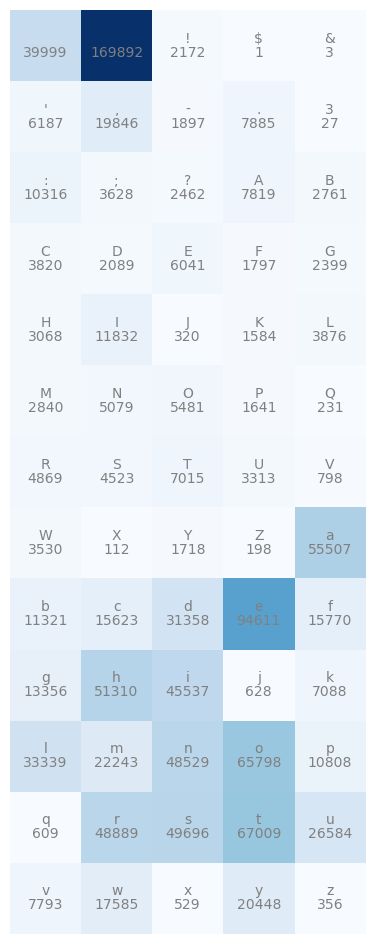

In [63]:
# map each character to an integer and vice versa
chars = sorted(set(corpus))
idx2char = dict(enumerate(chars))
char2idx = {v: k for (k, v) in idx2char.items()}
print(f'No. characteres: {len(corpus)}. Unique set: {chars}')

# Count number of occurrences of each character
char_counts = torch.zeros(len(chars), dtype = torch.int32)
for c in corpus:
    char_counts[char2idx[c]] += 1

# Display character counts
plt.figure(figsize=(12, 12))
plt.imshow(char_counts.view(-1, 5), cmap='Blues')
plt.axis('off')
for i in range(len(chars)):
    plt.text(i % 5, i//5, idx2char[i], ha='center', va='bottom', color='gray')
    plt.text(i % 5, i//5, char_counts[i].item(), ha='center', va='top', color='gray')

In [80]:
# Form dataset from corpus
block_size = 40 # context size for next character prediction

X, Y = [], []
for i in range(len(corpus[:100000])):
    if i < block_size: # skip first block_size characters
        continue
    X.append([char2idx[j] for j in  corpus[(i-block_size):i]])
    Y.append(char2idx[corpus[i]])
    
for i in range(5):
    # check the data looks as expected
    print(f'{i}. {"".join([idx2char[j] for j in X[i]])} --> {idx2char[Y[i]]}')
    print(f'{i}. {X[i]} --> {Y[i]}')

0. First Citizen:
Before we proceed any fur --> t
0. [18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56] --> 58
1. irst Citizen:
Before we proceed any furt --> h
1. [47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58] --> 46
2. rst Citizen:
Before we proceed any furth --> e
2. [56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46] --> 43
3. st Citizen:
Before we proceed any furthe --> r
3. [57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43] --> 56
4. t Citizen:
Before we proceed any further --> ,
4. [58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56

In [78]:
random.seed(42)
torch.manual_seed(42)

# shuffle data
idx_perm = torch.randperm(len(X))
X = [X[i] for i in idx_perm]
Y = [Y[i] for i in idx_perm]

# split data into train, validation and test sets
n1 = int(len(X)*0.8)
n2 = int(len(X)*0.9)
X_train, Y_train = X[:n1], Y[:n1]
X_val, Y_val = X[n1:n2], Y[n1:n2]
X_test, Y_test = X[n2:], Y[n2:]

print(f'X_train: {len(X_train)} | X_val: {len(X_val)} | X_test: {len(X_test)}')

X_train: 79960 | X_val: 9995 | X_test: 9995


# **Baseline model**